# Hierarchical model with automatic clustering (still under construction)
In this notebook, we will try to expand the code for the hierarchical latent variable model to include automatic cluster detection (as opposed to the interactive cluster selection as implemented by Bishop & Tipping). This also allows us to select clusters in the original space, instead of a visualized latent space, we might try to evaluate if this works better.

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
from utils import loadStan
import scipy
from sklearn.cluster import SpectralClustering
sns.set()

In [31]:
ppca_model = loadStan('ppca')
gmm_model = loadStan('gmm')
moppcas_model = loadStan('moppcas', recompile=True)
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a3ab86dda8f7604fb2e24a060f0ac5fc NOW.


Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model compiled succesfully.
Model saved succesfully to cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.


## Generating data
Data was generated according to the description in Bishop & Tippings paper.

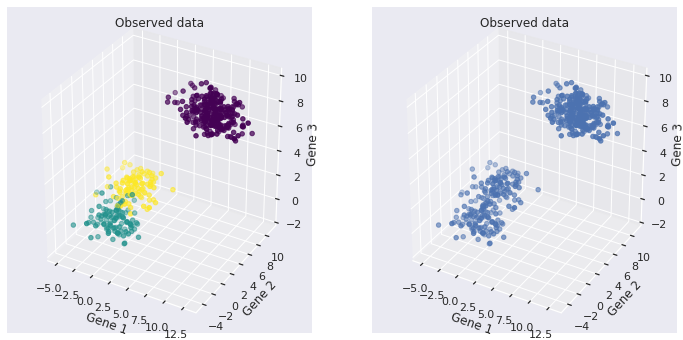

In [51]:
N=450
M=2
D=3
K=3

sig = 3

mu = np.random.normal(0,2,size=(K,D))
mu[0]+=np.random.uniform(2*sig,3*sig, size=D)

sigma = [np.random.uniform(sig/2,sig,size=(D)) for k in range(K)]
for k in range(K):
    flat_dim = np.random.randint(D)
    sigma[k][k]=sigma[k][flat_dim]/5
cov = [np.diag(sigma[k]) for k in range(K)]

while True:      # make sure to not have a negligible cluster
    theta = np.random.dirichlet(np.ones(K))
    if np.all(theta>(1.0/(2*K))):
        break
        
ind = np.ones(N)
x = np.zeros((N,D))

for n in range(N):
    opt = np.random.choice(list(range(K)), p=theta)
    ind[n] = opt
    newentry = np.random.multivariate_normal(mu[opt], cov[k])
    x[n,:] = newentry


    
sns.set()
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind, cmap='viridis')
# ax.scatter(mu[:,0], mu[:,1], mu[:,2])
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], cmap='viridis')
# ax.scatter(mu[:,0], mu[:,1], mu[:,2])
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

## First level: PPCA

In [52]:
ppca_dat = {'N':N, 'M':M, 'D':D, 'x':x}
fit = ppca_model.sampling(data=ppca_dat, iter=200, chains=1)
fitreturn = fit.extract()

best_ind = np.where(fitreturn['lp__']==max(fitreturn['lp__']))[0][0]

In [53]:
W_sim_ppca1 = np.mean(fitreturn['W'], axis=0)
sigma_sim_ppca1 = np.mean(fitreturn['sigma'], axis=0)
mu_sim_ppca1 = np.mean(fitreturn['mu'], axis=0)
latent_sim_ppca1 = fitreturn['z'][best_ind]

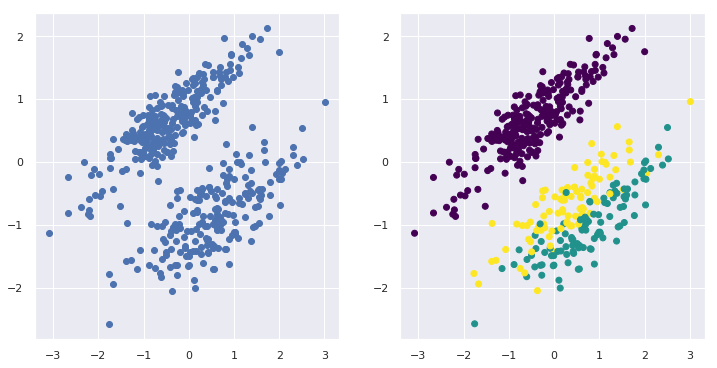

In [54]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.scatter(latent_sim_ppca1[0,:],latent_sim_ppca1[1,:])
ax = fig.add_subplot(122)
ax.scatter(latent_sim_ppca1[0,:],latent_sim_ppca1[1,:], c = ind, cmap='viridis')
plt.show()

## Second level: Mixture model on the latent space

### GAP-statistic for automatic clusternumber determination
As proposed by Tibshirani, Walther and Hastie(2000). We set a maximum of 2 sub-clusters, as we can always separate more clusters in the enxt layer, where the latent data will have a simpler form. This is because the GAP-statistic is biased towards round shapes and tends to find more clusters than there really are.

In [57]:
def GAP(points, k_max=2, nref=10):
    gap = []
    kmeans_list = []
    n,dims = np.shape(points)
    for K_clus in range(1,k_max+1):
        
        kmeans_init = KMeans(K_clus).fit(points)
        kmeans_list.append(kmeans_init)
        obs = np.log(kmeans_init.inertia_)
#         model = SpectralClustering(n_clusters=K_clus, affinity='nearest_neighbors',
#                            assign_labels='kmeans')
#         labels = model.fit_predict(points)
        
#         kmeans_list.append(labels)
        
        
#         centroids = [np.mean(points[labels==k],axis=0) for k in range(K_clus)]
#         print(K_clus,centroids)
#         mus = np.zeros((n,dims))
#         for k in range(K_clus):
#             mus[labels==k,:] = centroids[k]
#         sq_difs = np.sum(np.sqrt(np.sum((points-mus)**2,axis=0)))
#         obs = sq_difs
        exp = 0
        
#         for i in range(nref):
        tops = points.max(axis=0)
        bots = points.min(axis=0)
        dists = scipy.matrix(scipy.diag(tops-bots))
        rands = [scipy.random.random_sample(size=(n,dims)) for ref in range(nref)]
        for i in range(nref):
#             points_ref = np.array(rands[i]*dists+bots)
            points_ref = np.random.uniform(bots, tops, (n, dims))
            kmeans_ref = KMeans(K_clus).fit(points_ref)
            exp+=np.log(kmeans_ref.inertia_)
#             model_ref = SpectralClustering(n_clusters=K_clus, affinity='nearest_neighbors',
#                            assign_labels='kmeans')
#             labels_ref = model_ref.fit_predict(points_ref)
#             centroids_ref = [np.mean(points_ref[labels==k],axis=0) for k in range(K_clus)]
#             mus_ref = np.zeros((n,dims))
#             for k in range(K_clus):
#                 mus_ref[labels_ref==k,:] = centroids_ref[k]
#             sq_difs_ref = np.sum(np.sqrt(np.sum((points_ref-mus_ref)**2,axis=0)))
        
#             exp+= sq_difs_ref
            
        exp = exp/nref
#         exp2 = np.log((dims*n)/12)-(2/dims)*np.log(K_clus)
#         print(exp, exp2, exp-exp2, exp-obs, exp2-obs)
        gap.append(exp-obs)
        
    return list(range(1,k_max+1))[np.argmax(gap)], kmeans_list[np.argmax(gap)], gap

### Selecting the separate clusters in the latent space

We use the 2 dimensional PPCA plot to select what looks like two clusters, and then pass the selected points to a mixture model in the full, original space. The article of Bishop and Tipping selects the clusters manually, we use a $k$-means clustering algorithm to select the clusters in the latent space and then pass these clusters to the original space.

In [58]:
K_inter, clusters, gapscores = GAP(latent_sim_ppca1.T)
print('Estimated number of clusters: ', K_inter)

Estimated number of clusters:  2


In [59]:
clus_cent = clusters.cluster_centers_
gmm_dat = {'N': N,'K': K_inter, 'D':M, 'y':latent_sim_ppca1.T}
fit = gmm_model.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':clus_cent}])
fit_ext2 = fit.extract()
best_ind2 = np.where(fit_ext2['lp__']==max(fit_ext2['lp__']))[0][0]

In [60]:
clus_lat_gmm1 = np.mean(fit_ext2['z'],axis=0)
theta_sim_gmm1 = np.mean(fit_ext2['theta'],axis=0)
mu_sim_gmm1 = np.mean(fit_ext2['mu'],axis=0)
sigmas_sim_gmm1 = np.mean(fit_ext2['sigma'],axis=0)
clus_lat_norm_gmm1 = (np.exp(clus_lat_gmm1).T/sum(np.exp(clus_lat_gmm1).T))
clus_selec1 = np.argmax(clus_lat_norm_gmm1, axis=0)

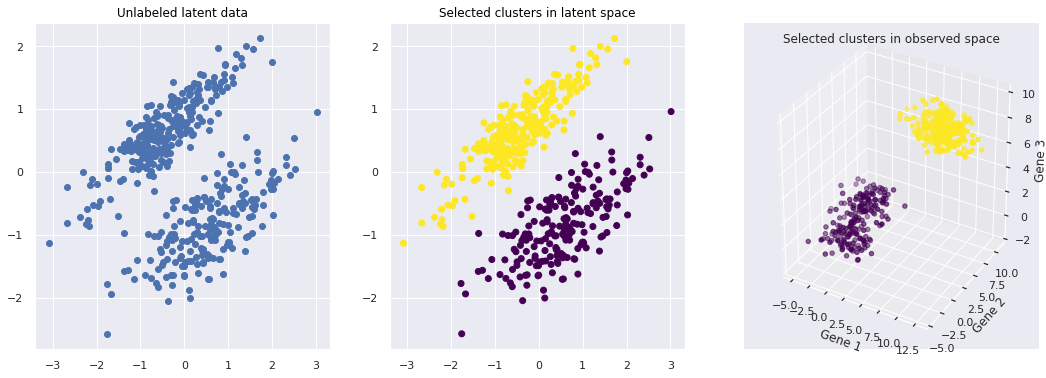

In [61]:
fig = plt.figure(figsize=(18,6))
ax=fig.add_subplot(1,3,1)
ax.scatter(latent_sim_ppca1[0,:],latent_sim_ppca1[1,:])
title = ax.set_title("Unlabeled latent data")
plt.setp(title, color='black') 
ax = fig.add_subplot(1,3,2)
ax.scatter(latent_sim_ppca1.T[:,0],latent_sim_ppca1.T[:,1], c=clus_selec1, cmap='viridis')
title = ax.set_title("Selected clusters in latent space")
plt.setp(title, color='black')
ax = fig.add_subplot(133, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=clus_selec1, cmap='viridis')
ax.set_title('Selected clusters in observed space')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

### Initializing the latent variable mixture model based on selected clusters

In [62]:
cc3d = [np.average(x[clus_selec1==k],axis=0, weights=clus_lat_norm_gmm1[k,:][clus_selec1==k]) for k in range(K_inter)]

gmm_dat = {'N': N,'M':M,'K': K_inter, 'D':D, 'y':x}
fit = moppcas_model.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':cc3d}])
fit_ext_molv1 = fit.extract()
best_ind_molv1 = np.where(fit_ext_molv1['lp__']==max(fit_ext_molv1['lp__']))[0][0]

latent_molv1 = fit_ext_molv1['z'][best_ind_molv1]
clus_molv1 = np.mean(fit_ext_molv1['clusters'],axis=0)
theta_molv1 = np.mean(fit_ext_molv1['theta'],axis=0)
mu_sim_molv1 = np.mean(fit_ext_molv1['mu'],axis=0)
sigmas_sim_molv1 = np.mean(fit_ext_molv1['sigma'],axis=0)
clus_norm_molv1 = (np.exp(clus_molv1).T/sum(np.exp(clus_molv1).T))

cats_full1 = np.argmax(clus_norm_molv1,axis=0)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


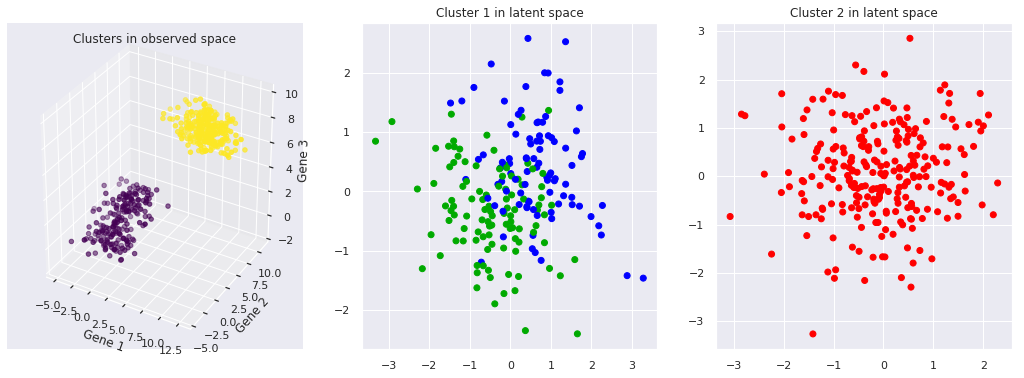

In [63]:
sns.set()
fig = plt.figure(figsize=((1+K_inter)*6,6))
ax=fig.add_subplot(1,1+K_inter,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=cats_full1, cmap='viridis')
ax.set_title('Clusters in observed space')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
for k in range(K_inter):
    ax=fig.add_subplot(1,1+K_inter,k+2)
    rgba_colors=np.zeros((sum(clus_norm_molv1[k,:]>0.01),4))
    for k_i in range(K):
        rgba_colors[ind[clus_norm_molv1[k,:]>0.01]==k_i,k_i] = 1.0
    rgba_colors[:,3] = clus_norm_molv1[k,:][clus_norm_molv1[k,:]>0.01]
    rgba_colors[:,1] = rgba_colors[:,1]/1.5
    ax.scatter(latent_molv1[k].T[:,0][clus_norm_molv1[k,:]>0.01],latent_molv1[k].T[:,1][clus_norm_molv1[k,:]>0.01], c=rgba_colors, cmap='viridis')
    ax.set_title('Cluster '+str(k+1)+' in latent space')
plt.show()

## Third level: Finding clusters in the individual latent spaces
Cluster 1 does not show an underlying structure (and it really doesn't exist out of different components) , so we'll leave it alone for now. We do see vague hints of underlying sub-clusters in cluster 2, so we'll try to extract those!

### Selecting sub-clusters in the latent space

In [72]:
subclusters = [GAP(latent_molv1[k].T) for k in range(K_inter)]

In [73]:
subclusters

[(2, KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
         n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
         random_state=None, tol=0.0001, verbose=0), [1.4693623489598302,
   1.344740377246076]),
 (2, KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
         n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
         random_state=None, tol=0.0001, verbose=0), [1.713622856426138,
   1.6012388442080798])]

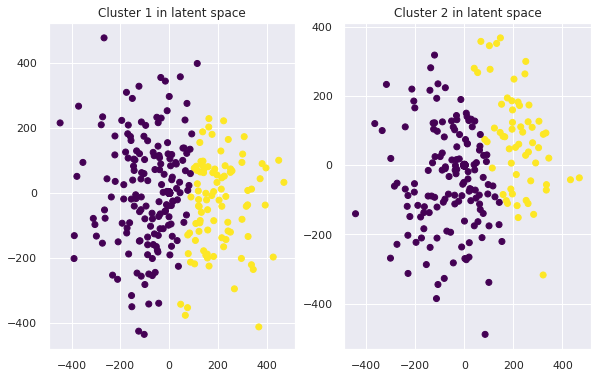

In [74]:
fig = plt.figure(figsize=(15,6))
for k in range(K_inter):
    ax=fig.add_subplot(1,1+K_inter,k+2)
    rgba_colors=np.zeros((N,4))
    rgba_colors[:,k] = 1.0
    rgba_colors[:,3] = clus_norm_molv1[k,:]
    rgba_colors[:,1] = rgba_colors[:,1]/1.5
#     ax.scatter(latent_molv1[k].T[:,0],latent_molv1[k].T[:,1], c=rgba_colors, cmap='viridis')
    ax.scatter(latent_molv1[k].T[:,0],latent_molv1[k].T[:,1], c=KMeans(subclusters[k][0]).fit(latent_molv1[k].T).labels_, cmap='viridis')
    ax.set_title('Cluster '+str(k+1)+' in latent space')
#     ax.scatter(subclusters[0][1][:,0],subclusters[0][1][:,1])
plt.show()

The GAP statistic is also not always able to notice two sub-clusters when they overlap a little. We can try to cluster in the original space.

In [75]:
subclusters = [GAP(x[cats_full1==k]) for k in range(K_inter)]

In [76]:
subclusters

[(2, KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
         n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
         random_state=None, tol=0.0001, verbose=0), [0.7688765035487819,
   0.8132602351937566]),
 (2, KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
         n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
         random_state=None, tol=0.0001, verbose=0), [1.0158682764988356,
   0.8033864686417633])]

Again, the sub-clusters were not found, sometimes the algorithm will find non-existent sub-clusters.

### Latent variable mixture model based on selected sub-clusters

In [77]:
sec_layer_moppcas = []
for k in range(K_inter):
    gmm_dat = {'N': N,'M':M,'K': subclusters[k][0], 'D':D, 'y':x, 'weights':np.ones((N,subclusters[k][0]))*clus_lat_norm_gmm1[k,:][np.newaxis].T}
    fit = moppcas_weighted.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':subclusters[k][1].cluster_centers_}])
    fit_ext_molv2 = fit.extract()
    best_molv2 = np.where(fit_ext_molv2['lp__']==max(fit_ext_molv2['lp__']))[0][0]
    sec_layer_moppcas.append([fit_ext_molv2,best_molv2])

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


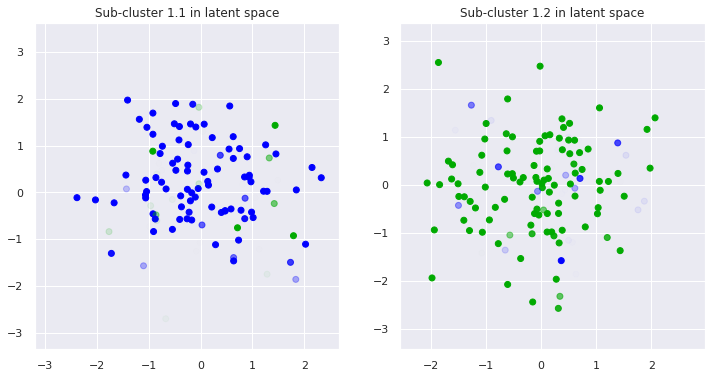

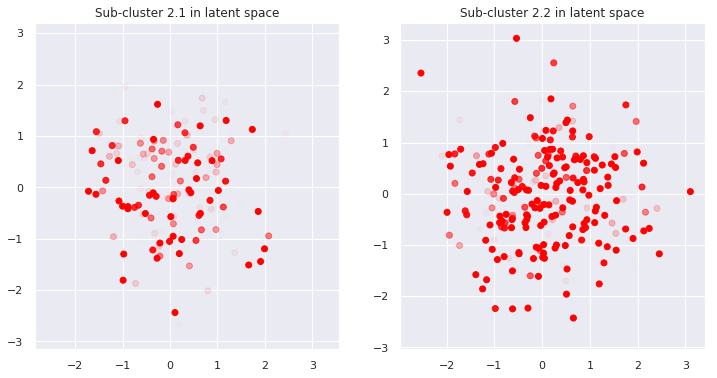

In [78]:
for clus in range(K_inter):
    fit_ext_molv2 = sec_layer_moppcas[clus][0]
    latent_molv2 = sec_layer_moppcas[clus][0]['z'][sec_layer_moppcas[clus][1]]
    clus_molv2 = np.mean(fit_ext_molv2['clusters'],axis=0)
    theta_sim_molv2 = np.mean(fit_ext_molv2['theta'],axis=0)
    mu_sim_molv2 = np.mean(fit_ext_molv2['mu'],axis=0)
    sigmas_sim_molv2 = np.mean(fit_ext_molv2['sigma'],axis=0)

    latent_prenorm_molv2 = np.exp(clus_molv2)/np.sum(np.exp(clus_molv2),axis=1)[np.newaxis].T
    latent_norm_molv2 = latent_prenorm_molv2*clus_norm_molv1[clus,:][np.newaxis].T
    total_probs = np.concatenate((clus_norm_molv1[0,:][np.newaxis].T,latent_norm_molv2),axis=1)
    cats_full2 = np.argmax(total_probs, axis=1)

    sns.set()
    K_last = subclusters[clus][0]
    fig = plt.figure(figsize=((K_last)*6,6))
    for k in range(K_last):
        ax=fig.add_subplot(1,K_last,k+1)
        rgba_colors=np.zeros((N,4))
        for k_i in range(K):
            rgba_colors[ind==k_i,k_i] = 1.0
        rgba_colors[:,3] = latent_norm_molv2[:,k]
        rgba_colors[:,1] = rgba_colors[:,1]/1.5
        ax.scatter(latent_molv2[k].T[:,0],latent_molv2[k].T[:,1], c=rgba_colors)
        ax.set_title('Sub-cluster '+str(clus+1)+'.'+str(k+1)+' in latent space')
    plt.show()

# Endresult of the hierarchical latent variable clustering model

In [79]:
all_latent = np.concatenate((latent_molv1[0][np.newaxis], latent_molv2),axis=0)

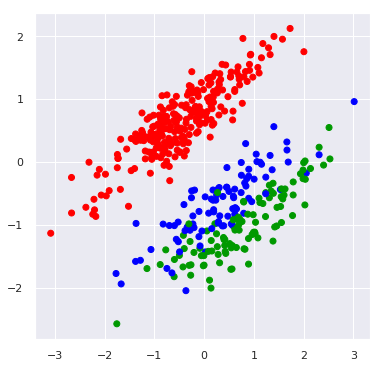

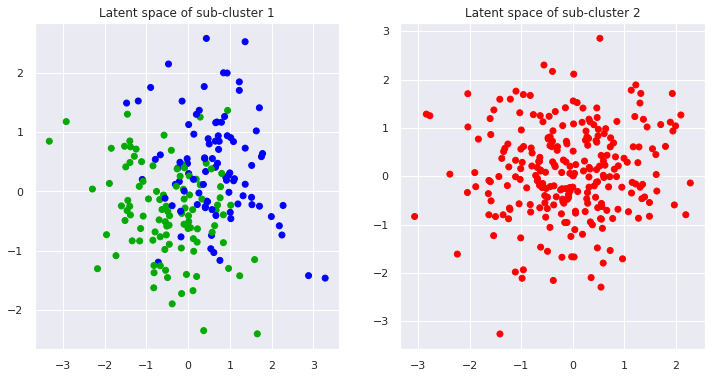

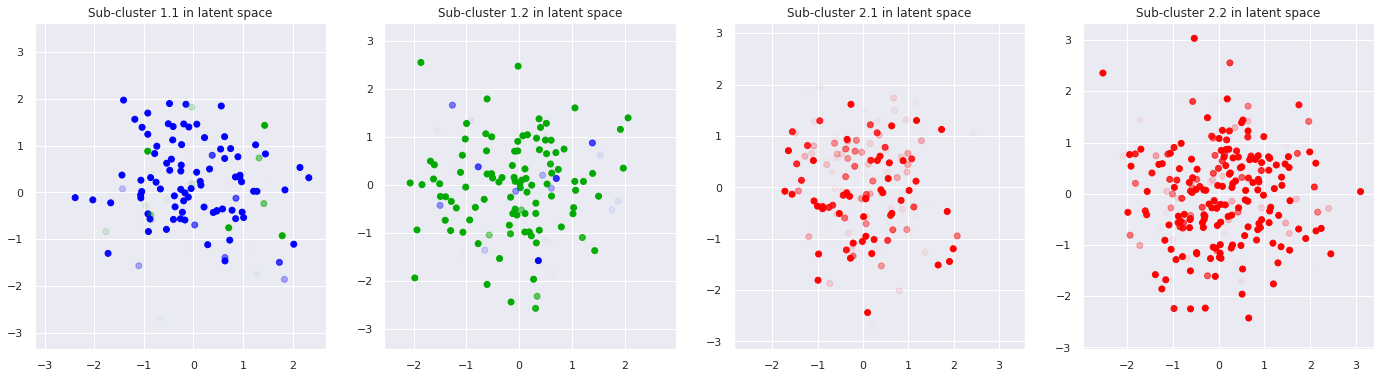

In [86]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
rgba_colors = np.zeros((N,4))
for k_i in range(K):
    rgba_colors[ind==k_i,k_i] = 1.0
rgba_colors[:,3] = 1.0
rgba_colors[:,1] = 0.6*rgba_colors[:,1]
ax.scatter(latent_sim_ppca1[0,:],latent_sim_ppca1[1,:], c=rgba_colors)
plt.show()

fig = plt.figure(figsize=(K_inter*6, 6))
for k in range(K_inter):
    ax = fig.add_subplot(1,K_inter,k+1)
    rgba_colors=np.zeros((sum(clus_norm_molv1[k,:]>0.01),4))
    for k_i in range(K):
        rgba_colors[ind[clus_norm_molv1[k,:]>0.01]==k_i,k_i] = 1.0
    rgba_colors[:,3] = clus_norm_molv1[k,:][clus_norm_molv1[k,:]>0.01]
    rgba_colors[:,1] = rgba_colors[:,1]/1.5
    ax.scatter(latent_molv1[k].T[:,0][clus_norm_molv1[k,:]>0.01],latent_molv1[k].T[:,1][clus_norm_molv1[k,:]>0.01], c=rgba_colors, cmap='viridis')
    ax.set_title('Latent space of sub-cluster '+str(k+1))
plt.show()

# fig = plt.figure(figsize=(K*6, 6))
# for k in range(K):
#     ax = fig.add_subplot(1,K_total,k+1)
#     rgba_colors = np.zeros((N,4))
#     for k_i in range(K):
#         rgba_colors[ind==k_i,k_i] = 1.0
#     rgba_colors[:,3] = total_probs[:,k]
#     rgba_colors[:,1] = 0.6*rgba_colors[:,1]
#     ax.scatter(all_latent[k][0,:],all_latent[k][1,:],c=rgba_colors)
#     ax.set_title('Latent space of sub-cluster '+str(k+1))
# plt.show()

K_sub = sum([k[0] for k in subclusters])
fig = plt.figure(figsize=(K_sub*6, 6))
count = 1
norms = []
for clus in range(K_inter):
    K_last = subclusters[clus][0]
    if clus == 1:
        K_last = 2
    fit_ext_molv2 = sec_layer_moppcas[clus][0]
    latent_molv2 = sec_layer_moppcas[clus][0]['z'][sec_layer_moppcas[clus][1]]
    clus_molv2 = np.mean(fit_ext_molv2['clusters'],axis=0)
    latent_prenorm_molv2 = np.exp(clus_molv2)/np.sum(np.exp(clus_molv2),axis=1)[np.newaxis].T
    latent_norm_molv2 = latent_prenorm_molv2*clus_norm_molv1[clus,:][np.newaxis].T
    norms.append(latent_norm_molv2.copy())
    for k in range(K_last):
            ax=fig.add_subplot(1,K_sub,count)
            rgba_colors=np.zeros((N,4))
            for k_i in range(K):
                rgba_colors[ind==k_i,k_i] = 1.0
            rgba_colors[:,3] = latent_norm_molv2[:,k]
            rgba_colors[:,1] = rgba_colors[:,1]/1.5
            ax.scatter(latent_molv2[k].T[:,0],latent_molv2[k].T[:,1], c=rgba_colors, cmap='viridis')
            ax.set_title('Sub-cluster '+str(clus+1)+'.'+str(k+1)+' in latent space')
            count+=1
total_norms = np.concatenate(norms, axis=1)
final_subclusters = np.argmax(total_norms,axis=1)

As suggested in the original article, the density of the ink in each dot represents the posterior probability of the datapoint belonging in the sub-cluster. The colours represent the true cluster in all plots.

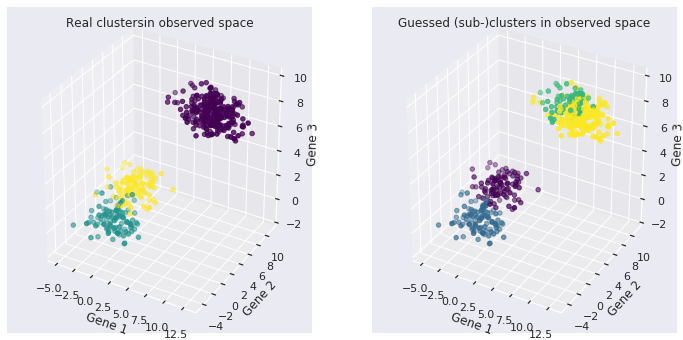

In [96]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind, cmap='viridis')
# ax.scatter(mu[:,0], mu[:,1], mu[:,2])
ax.set_title('Real clustersin observed space')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax=fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=final_subclusters, cmap='viridis')
ax.set_title('Guessed (sub-)clusters in observed space')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()